In [1]:
import os
import time
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from tqdm import tqdm
import seaborn as sns
import datetime
import time
import matplotlib.pyplot as plt
import statsmodels.stats as stat
import sys
import talib
import scipy.stats as stat
import sympy as sy
from sympy.stats import Normal, cdf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold
import sklearn
import joblib
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#import pickle5 as pickle
torch.cuda.empty_cache()
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
tqdm.pandas(desc="my bars:")
warnings.filterwarnings("ignore")

In [2]:
work_path = os.path.dirname(os.getcwd())
work_path = os.path.dirname(work_path)

In [3]:
work_path

'C:\\Users\\lenovo\\git_intro\\SabrSummerProject2022'

In [4]:
etf = pd.read_pickle(work_path+'\\03_data\\300etf.pkl')
option2207 = pd.read_pickle(work_path + '\\03_data\\300etf_option2207.pkl')

In [5]:
etf = etf.rename(columns = {'datetime':'time'})
etf['time'] = pd.to_datetime(etf['time'])
option2207['strike price'] = option2207['option_code'].apply(lambda x: int(x[-4:]))/1000
option2207['type'] = option2207['type'].apply(lambda x: 'C' if x == 1 else 'P')
option2207['time_to_mature'] = option2207['time'].apply(lambda x: x.date())
trading_date = np.sort(np.unique(option2207['time_to_mature']))
trading_interval = np.unique(option2207['time'].apply(lambda x: str(x.hour).zfill(2)+str(x.minute).zfill(2)))
option2207['time_to_mature'] = option2207['time_to_mature'].apply(lambda x: len(trading_date) + 1 - np.where(trading_date == x)[0][0])
option2207['time_to_mature'] = option2207['time_to_mature'] * len(trading_interval) + option2207['time'].apply(lambda x: len(trading_interval) - 1 - np.where(trading_interval == (str(x.hour).zfill(2)+str(x.minute).zfill(2)))[0][0])
trading_year = len(trading_interval) * 250
option2207['time_to_mature'] = option2207['time_to_mature'] / trading_year

In [6]:
option2207

,time,code,open,high,low,close,volume,option_code,type,maturity_date,strike,strike price,time_to_mature
0,2022-05-26 09:35:00,10004299.SH,0.3987,0.3987,0.3987,0.3987,1.0000,510300C2207M03600,C,2022-07-27 15:30:00,3.6000,3.6000,0.1839
1,2022-05-26 09:35:00,10004300.SH,0.3146,0.3146,0.3025,0.3025,3.0000,510300C2207M03700,C,2022-07-27 15:30:00,3.7000,3.7000,0.1839
2,2022-05-26 09:35:00,10004301.SH,0.2454,0.2454,0.2317,0.2361,16.0000,510300C2207M03800,C,2022-07-27 15:30:00,3.8000,3.8000,0.1839
3,2022-05-26 09:35:00,10004302.SH,0.1808,0.1808,0.1645,0.1718,293.0000,510300C2207M03900,C,2022-07-27 15:30:00,3.9000,3.9000,0.1839
4,2022-05-26 09:35:00,10004303.SH,0.1227,0.1244,0.1158,0.1180,220.0000,510300C2207M04000,C,2022-07-27 15:30:00,4.0000,4.0000,0.1839
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52699,2022-07-27 15:00:00,10004334.SH,0.4293,0.4293,0.4293,0.4293,0.0000,510300P2207M04700,P,2022-07-27 15:30:00,4.7000,4.7000,0.0080
52700,2022-07-27 15:00:00,10004379.SH,0.0001,0.0001,0.0001,0.0001,9.0000,510300C2207M04800,C,2022-07-27 15:30:00,4.8000,4.8000,0.0080
52701,2022-07-27 15:00:00,10004380.SH,0.5287,0.5287,0.5287,0.5287,0.0000,510300P2207M04800,P,2022-07-27 15:30:00,4.8000,4.8000,0.0080
52702,2022-07-27 15:00:00,10004391.SH,0.0001,0.0001,0.0001,0.0001,9.0000,510300C2207M04900,C,2022-07-27 15:30:00,4.9000,4.9000,0.0080


In [6]:
#####option_model######
sys.path.append(work_path + '\\02_src\\OptionModel')

In [7]:
from sabr_bywynn import BlackScholes, SABR

In [8]:
option2207['date'] = option2207['time'].apply(lambda x: x.date())
option2207 = pd.merge(option2207, etf.rename(columns = {'close':'spot price'})[['time','spot price']], how = 'left', on  = 'time')

In [10]:
def pandas_apply_sabr(temp):
    global params
    global r
    
    # drop deep itm call
    deepcall = temp.loc[(temp['type'] == 'C')&(temp['strike price'] < temp['spot price']-0.3), :]
    dropindex = deepcall.loc[deepcall['close']+deepcall['strike price'] > deepcall['spot price'], :].index
    temp = temp.drop(dropindex)
    # calculate black IV
    y = temp['strike price'].values
    expiry = temp['time_to_mature'].values[0]
    spot_price = temp['spot price'].values[0]
    isCall = temp['type'].apply(lambda x: True if x == 'C' else False)
    price = temp['close'].values
    BS = BlackScholes(y, expiry, spot_price, 0.04, isCall)
    bvol = BS.blackIV(price)
    # drop vol outlier
    bvol[bvol<0.08] = bvol[bvol>0.08].min()
    bvol[bvol>0.5] = np.NAN
    # check
    if len(bvol[~np.isnan(bvol)]) < 3:
        return temp
    # drop 10 delta
    bdelta = BS.blackDelta(bvol)
    argfit = (np.abs(bdelta) > 0.1)&(np.abs(bdelta) < 0.9)
    # fit sabr
    y = y[argfit]
    isCall = isCall[argfit]
    price = price[argfit]
    # volume = temp['volume'].values[argfit]
    # volume[volume < 1] = 1
    atm_spread = y[np.abs(y - spot_price).argmin()] - spot_price
    atm_index_c = np.where(y[isCall] == spot_price + atm_spread)
    atm_index_c = np.where(price == price[isCall][atm_index_c])
    atm_index_p = np.where(y[~isCall] == spot_price + atm_spread)
    atm_index_p = np.where(price == price[~isCall][atm_index_p])
    if atm_spread < 0:
        atm_index = atm_index_p
    else:
        atm_index = atm_index_c
    # use atm put call parity to calculate riskfree interest rate
    r_plus = -np.log((price[atm_index_p] - price[atm_index_c] + spot_price)/y[atm_index]) / expiry
    r = (4*r+r_plus[0])/5
    sabr = SABR(y, expiry, spot_price, r, isCall)
    param= sabr.haganFit_delta(sabr.BS, price, atm_index)
    temp = temp.loc[argfit, :]
    params[temp['time'].values[0]] = param
    temp['black vol'] = bvol[argfit]
    temp['sabr vol'] = sabr.haganLogNormalApprox(sabr.BS, param[0], param[1], param[2], param[3])
    temp['delta'] = sabr.computeSABRdelta(sabr.BS, param[0], param[1], param[2], param[3])
    temp['vega'] = sabr.computeSABRvega(sabr.BS, param[0], param[1], param[2], param[3])
    temp['theta'] = sabr.computeSABRtheta(sabr.BS, param[0], param[1], param[2], param[3])
    temp['gamma'] = sabr.computeSABRgamma(sabr.BS, param[0], param[1], param[2], param[3])
    temp['riskfree rate'] = r
    
    return temp

In [9]:
option2207_sabr = pd.read_pickle(work_path+'\\03_data\\300etf_2207_sabr_v1.pkl')
option2207_sabr_split = pd.read_pickle(work_path+'\\03_data\\300etf_2207_sabr_split_v1.pkl')

In [34]:
option2207_sabr_split

,time,code,open,high,low,close,volume,option_code,type,maturity_date,strike,strike price,time_to_mature,spot price,black vol,sabr vol,delta,vega,theta,gamma,riskfree rate
0,2022-05-26 09:35:00,10004300.SH,0.3146,0.3146,0.3025,0.3025,3.0000,510300C2207M03700,C,2022-07-27 15:30:00,3.7000,3.7000,0.1759,3.9770,0.1818,0.2176,0.7613,0.4123,0.0102,0.9330,-0.0027
1,2022-05-26 09:35:00,10004301.SH,0.2454,0.2454,0.2317,0.2361,16.0000,510300C2207M03800,C,2022-07-27 15:30:00,3.8000,3.8000,0.1759,3.9770,0.2001,0.2103,0.6666,0.5092,0.0120,1.0956,-0.0027
2,2022-05-26 09:35:00,10004302.SH,0.1808,0.1808,0.1645,0.1718,293.0000,510300C2207M03900,C,2022-07-27 15:30:00,3.9000,3.9000,0.1759,3.9770,0.1985,0.2043,0.5549,0.5835,0.0132,1.1831,-0.0027
3,2022-05-26 09:35:00,10004303.SH,0.1227,0.1244,0.1158,0.1180,220.0000,510300C2207M04000,C,2022-07-27 15:30:00,4.0000,4.0000,0.1759,3.9770,0.1949,0.1999,0.4354,0.6120,0.0135,1.1604,-0.0027
4,2022-05-26 09:35:00,10004304.SH,0.0819,0.0832,0.0758,0.0774,388.0000,510300C2207M04100,C,2022-07-27 15:30:00,4.1000,4.1000,0.1759,3.9770,0.1931,0.1972,0.3211,0.5828,0.0127,1.0281,-0.0027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28535,2022-07-27 15:00:00,10004334.SH,0.4293,0.4293,0.4293,0.4293,0.0000,510300P2207M04700,P,2022-07-27 15:30:00,4.7000,4.7000,0.0000,4.2760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28536,2022-07-27 15:00:00,10004379.SH,0.0001,0.0001,0.0001,0.0001,9.0000,510300C2207M04800,C,2022-07-27 15:30:00,4.8000,4.8000,0.0000,4.2760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28537,2022-07-27 15:00:00,10004380.SH,0.5287,0.5287,0.5287,0.5287,0.0000,510300P2207M04800,P,2022-07-27 15:30:00,4.8000,4.8000,0.0000,4.2760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28538,2022-07-27 15:00:00,10004391.SH,0.0001,0.0001,0.0001,0.0001,9.0000,510300C2207M04900,C,2022-07-27 15:30:00,4.9000,4.9000,0.0000,4.2760,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
option2207_sabr

,time,code,open,high,low,close,volume,option_code,type,maturity_date,strike,strike price,time_to_mature,spot price,black vol,sabr vol,delta,vega,theta,gamma,riskfree rate
0,2022-05-26 09:35:00,10004300.SH,0.3146,0.3146,0.3025,0.3025,3.0000,510300C2207M03700,C,2022-07-27 15:30:00,3.7000,3.7000,0.1759,3.9770,0.1818,0.2176,0.7613,0.4123,0.0102,0.9317,-0.0027
1,2022-05-26 09:35:00,10004301.SH,0.2454,0.2454,0.2317,0.2361,16.0000,510300C2207M03800,C,2022-07-27 15:30:00,3.8000,3.8000,0.1759,3.9770,0.2001,0.2103,0.6666,0.5092,0.0120,1.0960,-0.0027
2,2022-05-26 09:35:00,10004302.SH,0.1808,0.1808,0.1645,0.1718,293.0000,510300C2207M03900,C,2022-07-27 15:30:00,3.9000,3.9000,0.1759,3.9770,0.1985,0.2043,0.5549,0.5835,0.0132,1.1835,-0.0027
3,2022-05-26 09:35:00,10004303.SH,0.1227,0.1244,0.1158,0.1180,220.0000,510300C2207M04000,C,2022-07-27 15:30:00,4.0000,4.0000,0.1759,3.9770,0.1949,0.1999,0.4354,0.6120,0.0135,1.1595,-0.0027
4,2022-05-26 09:35:00,10004304.SH,0.0819,0.0832,0.0758,0.0774,388.0000,510300C2207M04100,C,2022-07-27 15:30:00,4.1000,4.1000,0.1759,3.9770,0.1931,0.1972,0.3211,0.5828,0.0127,1.0287,-0.0027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28535,2022-07-27 15:00:00,10004334.SH,0.4293,0.4293,0.4293,0.4293,0.0000,510300P2207M04700,P,2022-07-27 15:30:00,4.7000,4.7000,0.0000,4.2760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28536,2022-07-27 15:00:00,10004379.SH,0.0001,0.0001,0.0001,0.0001,9.0000,510300C2207M04800,C,2022-07-27 15:30:00,4.8000,4.8000,0.0000,4.2760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28537,2022-07-27 15:00:00,10004380.SH,0.5287,0.5287,0.5287,0.5287,0.0000,510300P2207M04800,P,2022-07-27 15:30:00,4.8000,4.8000,0.0000,4.2760,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28538,2022-07-27 15:00:00,10004391.SH,0.0001,0.0001,0.0001,0.0001,9.0000,510300C2207M04900,C,2022-07-27 15:30:00,4.9000,4.9000,0.0000,4.2760,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
option2207_sabr = pd.concat([option2207_sabr,pd.get_dummies(option2207_sabr.type)],axis=1)
option2207_sabr = option2207_sabr.dropna()
option2207_sabr = option2207_sabr.sort_values(['code','time'])

In [11]:
def euro_vanilla_option(S, K, T, r,sigma,isCall):
    d1 = (np.log(S / K) + (r  + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r  - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if isCall == 1:
        phi = 1
    else:
        phi = -1
    
    return phi*(S*stat.norm.cdf(phi*d1) - K*np.exp(-r*T)*stat.norm.cdf(phi*d2))

In [12]:
def BS_price(df):
    k = df['strike price']
    s = df['spot price']
    iscall = df['C']
    expiry = df['time_to_mature']
    rf = df['riskfree rate']
    sigma = df['sabr vol']
    return pd.Series({'sabr_value':euro_vanilla_option(s,k,expiry,rf,sigma,iscall)})

option2207_sabr['sabr_value'] = option2207_sabr.apply(lambda x:BS_price(x),axis=1).values

In [13]:
def beta_calculation(df):
    df = df[['strike','sabr vol','spot price','time','code']]
    df['moneyness'] = (df['spot price']>df['strike']).apply(lambda x:1 if x else 0)
    df_OTM = df[df['moneyness']<1]
    df_ITM = df[df['moneyness']==1]
    beta_OTM_ols = np.cov(df_OTM['sabr vol'],df_OTM['strike'])[0][1]/np.var(df_OTM['strike'])
    beta_ITM_ols = np.cov(df_ITM['sabr vol'],df_ITM['strike'])[0][1]/np.var(df_ITM['strike'])
    if df_OTM['strike'].max() != df_OTM['strike'].min():
        beta_OTM = -(df_OTM['sabr vol'].max() - df_OTM['sabr vol'].min())/ (df_OTM['strike'].max() - df_OTM['strike'].min())
    else:
        beta_OTM = 0
    if df_ITM['strike'].max() != df_ITM['strike'].min():
        beta_ITM = (df_ITM['sabr vol'].max() - df_ITM['sabr vol'].min())/ (df_ITM['strike'].max() - df_ITM['strike'].min())
    else:
        beta_ITM = 0
    df_OTM_sub = df_OTM[df_OTM['strike']>df_OTM['strike'].min()]
    df_ITM_sub = df_ITM[df_ITM['strike']>df_ITM['strike'].min()]
    df_OTM_sub['beta'] = -(df_OTM_sub['sabr vol'] - df_OTM['sabr vol'].min())/(df_OTM_sub['strike'] - df_OTM['strike'].min())
    df_ITM_sub['beta'] = (df_ITM_sub['sabr vol'] - df_ITM['sabr vol'].min())/(df_ITM_sub['strike'] - df_ITM['strike'].min())
    beta_OTM_avg = df_OTM_sub['beta'].mean()
    beta_ITM_avg = df_ITM_sub['beta'].mean()
    
    atm_strike = (df_OTM.strike.max() + df_ITM.strike.min())/2
    atm_vol = (df_OTM['sabr vol'].min() + df_OTM['sabr vol'].min())/2
    df['beta'] = (df['sabr vol'] - atm_vol)/(df['strike'] - atm_strike)
    df.loc[abs(df['beta'])>1,'beta'] = 0
    df['beta_ols_diff'] = abs(df['beta'] - df['moneyness'].apply(lambda x:beta_OTM_ols if x==0 else beta_ITM_ols))
    df['beta_diff'] = abs(df['beta'] - df['moneyness'].apply(lambda x:beta_OTM if x==0 else beta_ITM))
    df['beta_avg_diff'] = abs(df['beta'] - df['moneyness'].apply(lambda x:beta_OTM_avg if x==0 else beta_ITM_avg))
    df['atm_IV'] = atm_vol
    df = df.drop("moneyness",axis=1)
    return df
vol_beta = option2207_sabr.groupby('time',as_index=True).progress_apply(lambda x:beta_calculation(x))

my bars:: 100%|███████████████████████████████████████████████████████████████████| 2023/2023 [00:14<00:00, 136.42it/s]


In [14]:
option2207_sabr = pd.merge(option2207_sabr,vol_beta[["code","time","beta","beta_ols_diff","beta_diff","beta_avg_diff","atm_IV"]],on = ["code","time"])

In [15]:
option2207_sabr['volume'] = np.log(option2207_sabr['volume'])

In [16]:
import talib
#feature engineering
def feature_engineering(data):
    df = data.copy()
    df['close_ma_25min'] = talib.MA(df['close'],5)
    df['close_ma_75min'] = talib.MA(df['close'],15)
    df['close_ema_25min'] = talib.EMA(df['close'],5)
    df['close_ema_75min'] = talib.EMA(df['close'],15)
    df['close_ma_diff_5'] = df['close'] - df['close_ma_25min']
    df['close_ema_diff_5'] = df['close'] - df['close_ema_25min']
    df['volume_ema_50min'] = talib.EMA(df['volume'],10)
    df['volume_ema_150min'] = talib.EMA(df['volume'],30)
    df['volume_ema_diff'] = df['volume_ema_50min'] - df['volume_ema_150min']
    df['vol_diff'] = df['black vol'] - df['sabr vol']
    df['moneyness'] = df['spot price']/df['strike price']
    df['sabr_value_diff'] = df['close'] - df['sabr_value']
    
    return df

def feature_engineering_vol(data):
    '''
    feature engineering
    '''
    df = data.copy()
    df['close_ema_25min'] = talib.EMA(df['close'],5)
    df['close_ema_75min'] = talib.EMA(df['close'],15)
    df['close_ema_diff_5'] = df['close'] - df['close_ema_25min']
    df['volume_ema_50min'] = talib.EMA(df['volume'],10)
    df['volume_ema_150min'] = talib.EMA(df['volume'],30)
    df['volume_ema_diff'] = df['volume_ema_50min'] - df['volume_ema_150min']
    df['vol_diff'] = df['black vol'] - df['sabr vol']
    df['moneyness'] = df['spot price']/df['strike price']
    df['sabr_vol_diff_min'] = df['sabr vol'] - df['sabr vol'].rolling(60,min_periods = 10).min()
    # df['sabr_vol_diff_max'] = -df['sabr vol'] + df['sabr vol'].rolling(50,min_periods = 10).max()
    df['sabr_value_diff'] = df['close'] - df['sabr_value']
    df['vol_ema_25min'] = talib.EMA(df['sabr vol'],5)
    df['vol_ema_75min'] = talib.EMA(df['sabr vol'],15)
    df['vol_ema_diff_5'] = df['sabr vol'] - df['vol_ema_25min']
    df['vol_ema_diff_15'] = df['sabr vol'] - df['vol_ema_75min']
    df['IV_per_volume'] = df['sabr vol'].diff() / df['volume']
    df['IV_per_volume_diff'] = (df['black vol'] - df['sabr vol']).diff()/df['volume']
    df['sabr_value_per_volume'] = df['sabr_value'].diff()/df['volume']
    df['sabr_value_per_volume_diff'] = (df['close'] - df['sabr_value']).diff()/df['volume']
    df['ret'] = df['close'].pct_change()
    df['cummulative_ret_25min'] = df['ret'].rolling(5).sum()
    df['cummulative_ret_75min'] = df['ret'].rolling(15).sum()
    df['aroon_up_30'],df['aroon_in_30'] = talib.AROON(df['high'],df['close'],30)
    df['CCI'] = talib.CCI(df['high'],df['low'],df['close'],30)
    df['macd_close'] = talib.MACD(df['close'],10,30,6)[0]
    df['macd_sabr_value'] = talib.MACD(df['sabr_value'],10,30)[0]
    df['ULTOSC'] = talib.ULTOSC(df['high'], df['low'], df['close'], timeperiod1=6, timeperiod2=12, timeperiod3=24)
    df['atm_IV_ema_25min'] = talib.EMA(df['atm_IV'],5)
    df['atm_IV_ema_75min'] = talib.EMA(df['atm_IV'],15)
    df['atm_IV_MACD'] = talib.MACD(df['atm_IV'],10,30,6)[0]
       
    return df
    

In [17]:
feature = option2207_sabr.groupby('code').progress_apply(lambda x:feature_engineering_vol(x))

my bars:: 100%|████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 89.65it/s]


In [18]:
def make_dataset(data,y_pred='f_close_5min'):
    feature = data.copy()
    feature = feature.dropna()
    if y_pred =="f_close_5min":
        feature['f_close_5min'] = feature.groupby('code').apply(lambda x:x['close'].shift(-1)).values
    elif y_pred == "f_ret_5min":
        feature['f_ret_5min'] = feature.groupby('code').apply(lambda x:x['close'].pct_change().shift(-1)).values
    elif y_pred == "f_ret_direction":
        feature['f_ret_direction'] = ((feature.groupby('code').apply(lambda x:x['close'].shift(-1)))>0).apply(lambda x: 1 if x else 0)
    feature = feature.replace({np.inf:0,-np.inf:0})
    feature = feature.dropna()
    month_split = feature.time.apply(lambda x:x.month)
    feature_train = feature[month_split<7]
    feature_test = feature[month_split==7]
    X_train = feature_train.drop(['time','code','option_code','type','maturity_date',y_pred],axis=1)
    y_train = feature_train[y_pred]
    X_test = feature_test.drop(['time','code','option_code','type','maturity_date',y_pred],axis=1)
    y_test = feature_test[y_pred]

    return X_train,y_train,X_test,y_test,feature_train,feature_test,feature
X_train,y_train,X_test,y_test,feature_train,feature_test,feature = make_dataset(feature,'f_ret_5min')

In [22]:
ic = abs(feature.drop(['time','code','option_code','type','maturity_date'],axis=1).corr()['f_ret_5min']).sort_values(ascending=False)

In [26]:
ic

f_ret_5min                   1.0000
vol_ema_diff_5               0.0685
vol_ema_diff_15              0.0575
IV_per_volume                0.0547
ret                          0.0437
cummulative_ret_25min        0.0435
beta                         0.0392
moneyness                    0.0366
sabr_value_diff              0.0360
beta_diff                    0.0348
close_ema_diff_5             0.0344
sabr_vol_diff_min            0.0342
vega                         0.0332
black vol                    0.0311
IV_per_volume_diff           0.0307
sabr_value_per_volume_diff   0.0306
C                            0.0305
P                            0.0305
beta_avg_diff                0.0303
ULTOSC                       0.0290
vol_diff                     0.0283
sabr vol                     0.0263
time_to_mature               0.0252
gamma                        0.0233
spot price                   0.0223
vol_ema_25min                0.0203
CCI                          0.0203
sabr_value_per_volume       

Text(0, 0.5, 'IC')

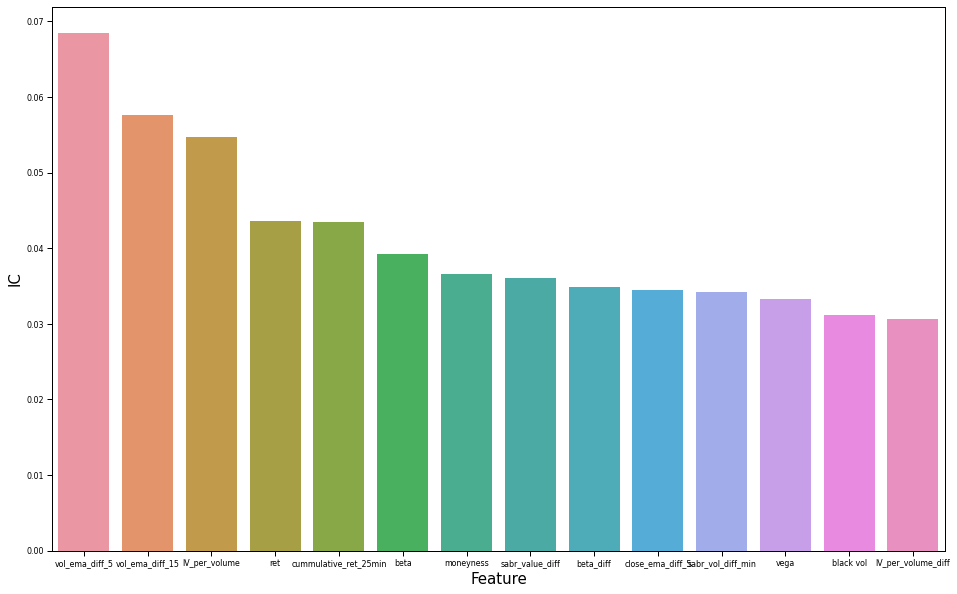

In [25]:
sns.set_context("paper", font_scale=0.9) 
plt.figure(figsize=(16, 10))
sns.barplot(x = ic.index[1:15],y = ic.values[1:15])
plt.xlabel("Feature", size=15)
plt.ylabel("IC", size=15)

In [80]:
feature.drop(['time','code','option_code','type','maturity_date'],axis=1).corr()['f_ret_5min'].sort_values()

vol_ema_diff_5          -0.0742
vol_ema_diff_15         -0.0629
IV_per_volume           -0.0576
cummulative_ret_25min   -0.0455
ret                     -0.0423
moneyness               -0.0377
sabr_value_diff         -0.0375
beta_diff               -0.0362
close_ema_diff_5        -0.0351
black vol               -0.0324
P                       -0.0306
vol_diff                -0.0305
beta_avg_diff           -0.0303
gamma                   -0.0293
ULTOSC                  -0.0288
sabr vol                -0.0272
spot price              -0.0228
vol_ema_25min           -0.0208
CCI                     -0.0204
vol_ema_75min           -0.0176
atm_IV_MACD             -0.0149
cummulative_ret_75min   -0.0129
theta                   -0.0117
volume_ema_150min       -0.0116
atm_IV                  -0.0109
volume                  -0.0082
volume_ema_50min        -0.0077
close                   -0.0068
sabr_value              -0.0064
high                    -0.0061
low                     -0.0057
close_em

In [25]:
feature.describe()

,open,high,low,close,volume,strike,strike price,time_to_mature,spot price,black vol,sabr vol,delta,vega,theta,gamma,riskfree rate,C,P,sabr_value,beta,beta_ols_diff,beta_diff,beta_avg_diff,close_ema_5min,close_ema_15min,close_ema_diff_5,volume_ema_10min,volume_ema_30min,volume_ema_diff,vol_diff,moneyness,sabr_value_diff,vol_ema_5min,vol_ema_15min,vol_ema_diff_5,vol_ema_diff_15,IV_per_volume,f_close_1min,f_ret_1min,f_ret_direction
count,26199.0000,26199.0000,26199.0000,26199.0000,26199.0000,26199.0000,26199.0000,26199.0000,26199.0000,26199.0000,26199.0000,26199.0000,26199.0000,26199.0000,26199.0000,26199.0000,26199.0000,26199.0000,26199.0000,25667.0000,25052.0000,25667.0000,25052.0000,26091.0000,25821.0000,26091.0000,12675.0000,12317.0000,12302.0000,26199.0000,26199.0000,26199.0000,26091.0000,25821.0000,26091.0000,25821.0000,26172.0000,26172.0000,26172.0000,26199.0000
mean,0.1241,0.1260,0.1221,0.1240,6.0419,4.2956,4.2956,0.1046,4.2872,0.2067,0.2072,-0.0391,0.2715,0.0251,1.2438,-0.0116,0.4746,0.5254,0.1242,-0.0218,0.0385,0.1022,0.0750,0.1239,0.1236,-0.0001,6.3498,6.3826,0.0096,-0.0005,1.0006,-0.0002,0.2072,0.2072,-0.0000,-0.0000,0.0000,0.1240,-0.0000,0.4728
std,0.1042,0.1047,0.1036,0.1042,2.1680,0.2651,0.2651,0.0443,0.1562,0.0141,0.0134,0.5309,0.1154,0.0111,0.6259,0.0101,0.4994,0.4994,0.1044,0.0669,0.0344,0.0780,0.0544,0.1038,0.1029,0.0035,1.3983,1.3364,0.2359,0.0040,0.0505,0.0015,0.0133,0.0131,0.0012,0.0021,0.0003,0.1041,0.0408,0.4993
min,0.0037,0.0038,0.0030,0.0033,0.0000,3.6000,3.6000,0.0074,3.9350,0.1315,0.1420,-0.9205,0.0201,-0.0134,0.3277,-0.0580,0.0000,0.0000,0.0036,-0.9130,0.0000,0.0000,0.0000,0.0039,0.0052,-0.0366,0.0000,0.0000,-1.1559,-0.0408,0.8973,-0.0159,0.1455,0.1554,-0.0139,-0.0179,-0.0091,0.0033,-0.4366,0.0000
25%,0.0362,0.0373,0.0352,0.0362,4.8203,4.1000,4.1000,0.0698,4.1760,0.1985,0.1990,-0.5052,0.1847,0.0171,0.8827,-0.0177,0.0000,0.0000,0.0361,-0.0536,0.0162,0.0459,0.0315,0.0363,0.0364,-0.0014,5.2624,5.2720,-0.1358,-0.0015,0.9598,-0.0006,0.1991,0.1991,-0.0006,-0.0011,-0.0001,0.0362,-0.0192,0.0000
50%,0.0909,0.0931,0.0885,0.0908,6.5396,4.3000,4.3000,0.1082,4.3120,0.2061,0.2066,-0.1160,0.2675,0.0256,1.1420,-0.0131,0.0000,1.0000,0.0908,0.0000,0.0323,0.0888,0.0667,0.0908,0.0908,-0.0001,6.4412,6.4419,0.0095,-0.0001,0.9978,-0.0001,0.2066,0.2066,0.0000,-0.0000,-0.0000,0.0908,0.0000,0.0000
75%,0.1911,0.1942,0.1881,0.1911,7.7151,4.5000,4.5000,0.1425,4.4160,0.2152,0.2157,0.4119,0.3512,0.0325,1.3904,-0.0052,1.0000,1.0000,0.1914,0.0157,0.0504,0.1398,0.1083,0.1908,0.1896,0.0012,7.4793,7.4760,0.1629,0.0009,1.0383,0.0003,0.2157,0.2156,0.0006,0.0010,0.0001,0.1910,0.0191,1.0000
max,0.4740,0.4740,0.4740,0.4740,10.2227,4.9000,4.9000,0.1759,4.5520,0.3046,0.2560,0.9018,0.6240,0.0897,5.9055,0.0163,1.0000,1.0000,0.4658,0.2122,0.4013,0.9130,0.3840,0.4680,0.4587,0.0516,9.2755,9.0424,0.8904,0.0644,1.1378,0.0216,0.2537,0.2517,0.0163,0.0211,0.0104,0.4740,0.4872,1.0000


In [81]:
import lightgbm as lgb
import sklearn as sk

In [57]:
#set training set and test set

# feature = feature.dropna()
# month_split = feature.time.apply(lambda x:x.month)
# feature_train = feature[month_split<7]
# feature_test = feature[month_split==7]
# X_train = feature_train.drop(['time','code','option_code','type','maturity_date','f_close_1min'],axis=1)
# y_train = feature_train['f_close_1min']
# X_test = feature_test.drop(['time','code','option_code','type','maturity_date','f_close_1min'],axis=1)
# y_test = feature_test['f_close_1min']
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)


In [92]:
feature_train.to_csv("feature_train_ret_5min.csv")
feature_test.to_csv("feature_test_ret_5min.csv")

In [120]:
#set lgbm params
#set params
params = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':'rmse',
    'learning_rate':0.05,
    'n_estimators':100,
    'reg_alpha':0.7,
    'num_leaves':10,
    'min_data_in_leaf':20
}


In [121]:
#start lgbm training
#start training
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=15,
                valid_sets=lgb_eval,
                early_stopping_rounds=10)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6915
[LightGBM] [Info] Number of data points in the train set: 17832, number of used features: 31
[LightGBM] [Info] Start training from score 0.133890
[1]	valid_0's rmse: 0.0869982
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 0.0828456
[3]	valid_0's rmse: 0.0788776
[4]	valid_0's rmse: 0.0750738
[5]	valid_0's rmse: 0.0714792
[6]	valid_0's rmse: 0.0680336
[7]	valid_0's rmse: 0.0647868
[8]	valid_0's rmse: 0.0616793
[9]	valid_0's rmse: 0.0587276
[10]	valid_0's rmse: 0.0559337
[11]	valid_0's rmse: 0.0532986
[12]	valid_0's rmse: 0.0507554
[13]	valid_0's rmse: 0.0483631
[14]	valid_0's rmse: 0.0460593
[15]	valid_0's rmse: 0.0439018
[16]	valid_0's rmse: 0.0418745
[17]	valid_0's rmse: 0.0398

In [122]:
y_pred = gbm.predict(X_test)
y_pred

array([0.28231224, 0.28524783, 0.28839974, ..., 0.41845517, 0.40258061,
       0.40258061])

In [124]:
gbm.feature_importance()

array([ 17,  54,  85, 271,   1,   0,   0,   0,   3,   5,  10,  13,  41,
         8,  23,   4,   0,   0, 223,  12,  21,  32,  16,   6,   0,   2,
         0,  34,   0,  19,   0])

In [36]:
#lgbm grid search
#grid search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
estimator = lgb.LGBMRegressor()
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [10,20,50,100],
    'reg_alpha':[0.3,0.5,0.7],
    'num_leaves':[8,16,31],
    'min_data_in_leaf':[20,50]
}
kfold = KFold(n_splits=10, shuffle = True,random_state=7)
gbm = GridSearchCV(estimator, param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv = kfold)
gbm.fit(X_train, y_train,eval_set=[(X_test, y_test)],
        early_stopping_rounds=5)

[1]	valid_0's l2: 0.00679856
[2]	valid_0's l2: 0.0055378
[3]	valid_0's l2: 0.00451472
[4]	valid_0's l2: 0.00367896
[5]	valid_0's l2: 0.00300493
[6]	valid_0's l2: 0.00245442
[7]	valid_0's l2: 0.00200279
[8]	valid_0's l2: 0.00164171
[9]	valid_0's l2: 0.00134177
[10]	valid_0's l2: 0.00110215
[11]	valid_0's l2: 0.00090475
[12]	valid_0's l2: 0.00074546
[13]	valid_0's l2: 0.000613196
[14]	valid_0's l2: 0.000506557
[15]	valid_0's l2: 0.000420893
[16]	valid_0's l2: 0.000348544
[17]	valid_0's l2: 0.000289905
[18]	valid_0's l2: 0.000243397
[19]	valid_0's l2: 0.000205088
[20]	valid_0's l2: 0.000172181
[21]	valid_0's l2: 0.000144992
[22]	valid_0's l2: 0.00012427
[23]	valid_0's l2: 0.000107198
[24]	valid_0's l2: 9.2889e-05
[25]	valid_0's l2: 8.017e-05
[26]	valid_0's l2: 7.0565e-05
[27]	valid_0's l2: 6.19944e-05
[28]	valid_0's l2: 5.52347e-05
[29]	valid_0's l2: 4.99312e-05
[30]	valid_0's l2: 4.50092e-05
[31]	valid_0's l2: 4.11236e-05
[32]	valid_0's l2: 3.77188e-05
[33]	valid_0's l2: 3.51728e-05
[34]

GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'min_data_in_leaf': [20, 50],
                         'n_estimators': [10, 20, 50, 100],
                         'num_leaves': [8, 16, 31],
                         'reg_alpha': [0.3, 0.5, 0.7]},
             scoring='neg_mean_squared_error')

In [37]:
gbm.best_params_

{'learning_rate': 0.1,
 'min_data_in_leaf': 50,
 'n_estimators': 100,
 'num_leaves': 31,
 'reg_alpha': 0.3}

Text(0, 0.5, 'Feature importance')

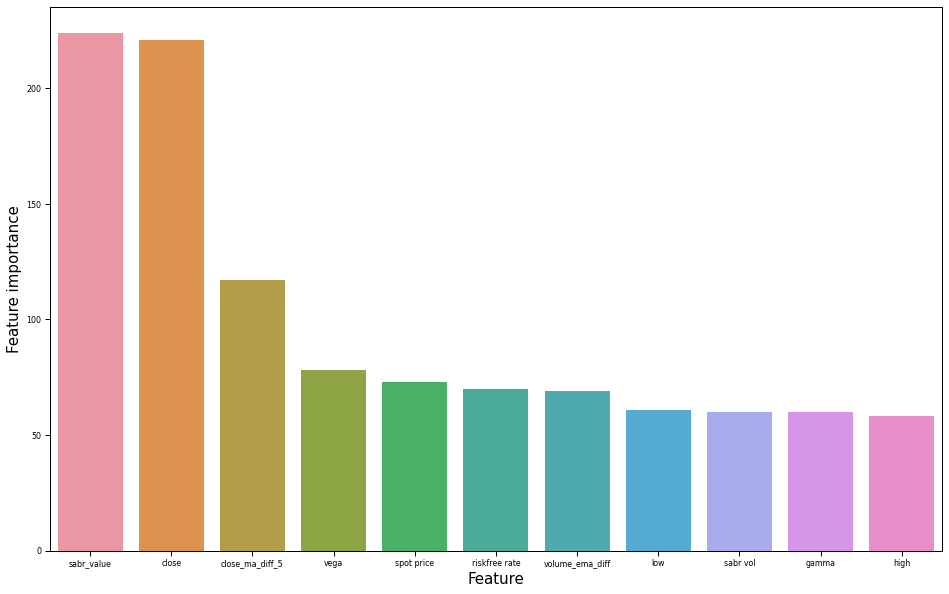

In [54]:
gbm_best_estimator = gbm.best_estimator_
gbm_best_estimator.feature_importances_
feature_importance = pd.Series(data = gbm_best_estimator.feature_importances_,index=X_train.columns).sort_values(ascending = False)
sns.set_context("paper", font_scale=0.9) 
plt.figure(figsize=(16, 10))
sns.barplot(x = feature_importance.index[:11],y = feature_importance.values[:11])
plt.xlabel("Feature", size=15)
plt.ylabel("Feature importance", size=15)

In [66]:
gbm_best_estimator.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('l2', 1.994532860340792e-05)])})

In [55]:
#save best result
joblib.dump(gbm_best_estimator, 'best_lgbm_model.pkl')
#joblib.load('best_lgbm_model.pkl')


['best_lgbm_model.pkl']

In [23]:
#set training set and test set with raw features
raw_feature_list = [ 'open', 'high', 'low', 'close', 'volume','time_to_mature','black vol', 'sabr vol','delta', 'vega', 'theta',
       'gamma', 'riskfree rate', 'C', 'P','sabr_value', 'moneyness','sabr_value_diff']
X_train_raw = feature_train[raw_feature_list]
y_train_raw = feature_train['f_close_1min']
X_test_raw = feature_test[raw_feature_list]
y_test_raw = feature_test['f_close_1min']
lgb_train_raw = lgb.Dataset(X_train_raw, y_train_raw)
lgb_eval_raw = lgb.Dataset(X_test_raw, y_test_raw, reference=lgb_train_raw)

In [57]:
#grid search
estimator = lgb.LGBMRegressor()
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [10,20,50,100],
    'reg_alpha':[0.3,0.5,0.7],
    'num_leaves':[8,16,31],
    'min_data_in_leaf':[20,50]
}
kfold = KFold(n_splits=10, shuffle = True,random_state=7)
gbm = GridSearchCV(estimator, param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv=kfold)
gbm.fit(X_train_raw, y_train_raw,eval_set=[(X_test_raw, y_test_raw)],
        early_stopping_rounds=5)

[1]	valid_0's l2: 0.00679963
[2]	valid_0's l2: 0.00554198
[3]	valid_0's l2: 0.00451426
[4]	valid_0's l2: 0.00368266
[5]	valid_0's l2: 0.00300193
[6]	valid_0's l2: 0.00245573
[7]	valid_0's l2: 0.00200521
[8]	valid_0's l2: 0.00164257
[9]	valid_0's l2: 0.0013432
[10]	valid_0's l2: 0.00110274
[11]	valid_0's l2: 0.000907421
[12]	valid_0's l2: 0.000745613
[13]	valid_0's l2: 0.000616029
[14]	valid_0's l2: 0.000510335
[15]	valid_0's l2: 0.000422058
[16]	valid_0's l2: 0.000351674
[17]	valid_0's l2: 0.000292083
[18]	valid_0's l2: 0.000245032
[19]	valid_0's l2: 0.000205778
[20]	valid_0's l2: 0.000172684
[21]	valid_0's l2: 0.000146971
[22]	valid_0's l2: 0.000125095
[23]	valid_0's l2: 0.000106611
[24]	valid_0's l2: 9.23306e-05
[25]	valid_0's l2: 7.9978e-05
[26]	valid_0's l2: 7.04256e-05
[27]	valid_0's l2: 6.19881e-05
[28]	valid_0's l2: 5.5469e-05
[29]	valid_0's l2: 4.97638e-05
[30]	valid_0's l2: 4.52369e-05
[31]	valid_0's l2: 4.13216e-05
[32]	valid_0's l2: 3.83445e-05
[33]	valid_0's l2: 3.53999e-05

GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
             estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'min_data_in_leaf': [20, 50],
                         'n_estimators': [10, 20, 50, 100],
                         'num_leaves': [8, 16, 31],
                         'reg_alpha': [0.3, 0.5, 0.7]},
             scoring='neg_mean_squared_error')

In [58]:
gbm.best_params_

{'learning_rate': 0.1,
 'min_data_in_leaf': 50,
 'n_estimators': 100,
 'num_leaves': 16,
 'reg_alpha': 0.3}

Text(0, 0.5, 'Feature importance')

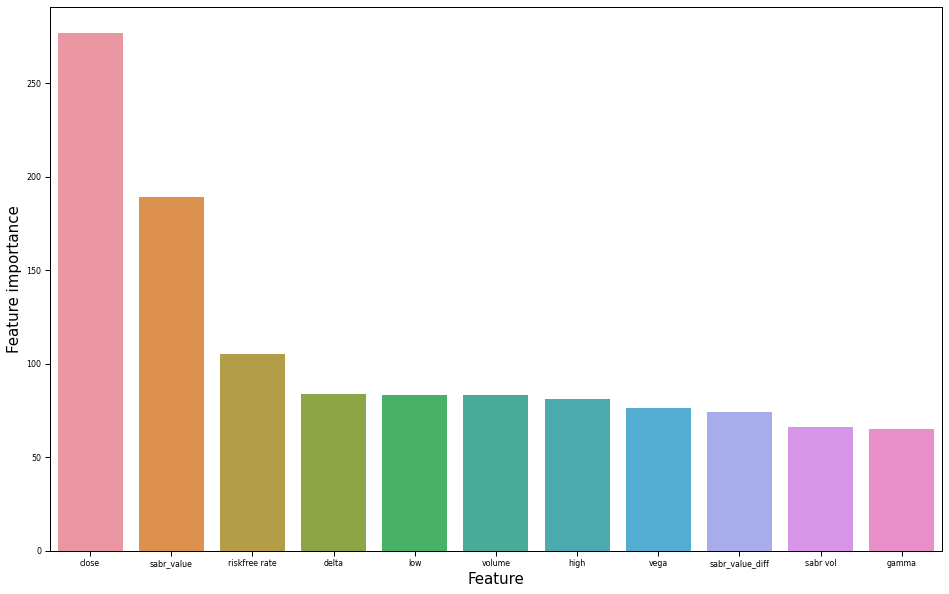

In [61]:
gbm_raw_best_estimator = gbm.best_estimator_
gbm_raw_best_estimator.feature_importances_
feature_importance = pd.Series(data = gbm_raw_best_estimator.feature_importances_,index=X_train_raw.columns).sort_values(ascending = False)
sns.set_context("paper", font_scale=0.9) 
plt.figure(figsize=(16, 10))
sns.barplot(x = feature_importance.index[:11],y = feature_importance.values[:11])
plt.xlabel("Feature", size=15)
plt.ylabel("Feature importance", size=15)

In [67]:
gbm_raw_best_estimator.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('l2', 1.970567168547753e-05)])})

In [63]:
#save best model
joblib.dump(gbm_raw_best_estimator, 'best_lgbm_raw_model.pkl')

['best_lgbm_raw_model.pkl']

In [20]:
#RandomForest grid Search
from sklearn.ensemble import RandomForestRegressor
estimator = RandomForestRegressor()
param_grid = {
    'n_estimators':[10,20,50,100],
    'max_features':['auto',10,20]
}
kfold = KFold(n_splits=10, shuffle = True,random_state=7)
rf = GridSearchCV(estimator, param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv=kfold)
rf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': ['auto', 10],
                         'n_estimators': [10, 20, 50, 100]},
             scoring='neg_mean_squared_error')

In [21]:
rf.best_params_

{'max_features': 10, 'n_estimators': 100}

In [23]:
joblib.dump(rf, 'best_randomforest_model.pkl')

['best_randomforest_model.pkl']

In [24]:
#RandomForest grid search raw feature
estimator = RandomForestRegressor()
param_grid = {
    'n_estimators':[10,20,50,100],
    'max_features':['auto',10],  
}
kfold = KFold(n_splits=10, shuffle = True,random_state=7)
rf = GridSearchCV(estimator, param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv=kfold)
rf.fit(X_train_raw, y_train_raw)

GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': ['auto', 10],
                         'n_estimators': [10, 20, 50, 100]},
             scoring='neg_mean_squared_error')

In [25]:
rf.best_params_

{'max_features': 10, 'n_estimators': 100}

In [26]:
joblib.dump(rf, 'best_randomforest_raw_model.pkl') 

['best_randomforest_raw_model.pkl']

In [23]:
torch.__version__

'1.10.2+cpu'

In [24]:
#neural network

train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda")
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

No GPU found. Please use a GPU to train your neural network.


In [25]:
batch_size = 16
epochs = 100
learn_rate = 0.001
X_train_tensor = torch.from_numpy(X_train.values)
y_train_tensor = torch.from_numpy(y_train.values)
X_test_tensor = torch.from_numpy(X_test.values)
y_test_tensor = torch.from_numpy(y_test.values)
dataset_tensor = TensorDataset(X_train_tensor,y_train_tensor)
data_loader = DataLoader(dataset_tensor,shuffle=True,batch_size = batch_size)
test_tensor = TensorDataset(X_test_tensor,y_test_tensor)
test_loader = DataLoader(test_tensor,shuffle=True,batch_size = batch_size)

In [25]:
class Net(nn.Module):
    def __init__(self,hidden_dim1,hidden_dim2,hidden_dim3):
        super(Net, self).__init__()
        
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.fc1 = nn.Linear(31, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1,hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2,hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3,1)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        
        x = F.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x
nn_sabr = Net(16,16,8)

In [97]:
loss_function = nn.MSELoss()
optimizier = optim.Adam(nn_sabr.parameters(),lr=learn_rate)

In [98]:
train_losses = []
nn_sabr = nn_sabr.double()
nn_sabr.train()
for epoch in range(epochs):
    running_loss = 0
    for features,target in data_loader:
        optimizier.zero_grad()
        output = nn_sabr(features)
        loss = loss_function(output, target)
        loss.backward()
        optimizier.step()
        running_loss += loss.item()*features.size(0)
    running_loss = running_loss/len(data_loader.dataset)
    train_losses.append(running_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        running_loss
        ))

Epoch: 1 	Training Loss: 0.011659
Epoch: 2 	Training Loss: 0.011315
Epoch: 3 	Training Loss: 0.011296
Epoch: 4 	Training Loss: 0.011288
Epoch: 5 	Training Loss: 0.011294
Epoch: 6 	Training Loss: 0.011285
Epoch: 7 	Training Loss: 0.011288
Epoch: 8 	Training Loss: 0.011286
Epoch: 9 	Training Loss: 0.011296
Epoch: 10 	Training Loss: 0.011283
Epoch: 11 	Training Loss: 0.011287
Epoch: 12 	Training Loss: 0.011280
Epoch: 13 	Training Loss: 0.011284
Epoch: 14 	Training Loss: 0.011286
Epoch: 15 	Training Loss: 0.011282
Epoch: 16 	Training Loss: 0.011287
Epoch: 17 	Training Loss: 0.011287
Epoch: 18 	Training Loss: 0.011290
Epoch: 19 	Training Loss: 0.011294
Epoch: 20 	Training Loss: 0.011279
Epoch: 21 	Training Loss: 0.011284
Epoch: 22 	Training Loss: 0.011284
Epoch: 23 	Training Loss: 0.011285
Epoch: 24 	Training Loss: 0.011277
Epoch: 25 	Training Loss: 0.011280
Epoch: 26 	Training Loss: 0.011282
Epoch: 27 	Training Loss: 0.011280
Epoch: 28 	Training Loss: 0.011285
Epoch: 29 	Training Loss: 0.0

In [100]:
test_loss = 0
nn_sabr.eval()
for features,target in test_loader:
    output = nn_sabr(features)
    loss = loss_function(output, target)
    test_loss += loss.item() * features.size(0)
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.008543



In [23]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [44]:
#grid search with ray tune
def grid_train_nn(config,epoches = 50,checkpoint_dir = None):
    nn_sabr = Net(config["l1"],config["l2"],config["l3"])
    nn_sabr = nn_sabr.double()
    nn_sabr.train()
    criterion = nn.MSELoss()
    optimizier = optim.SGD(nn_sabr.parameters(),lr = config["lr"])
    train_loader = DataLoader(dataset_tensor,shuffle=True,batch_size = int(config["batch_size"]))
    for epoch in range(epoches):
        running_loss = 0
        for features,target in train_loader:
            optimizier.zero_grad()
            outputs = nn_sabr(features)
            loss = criterion(outputs,target)
            loss.backward()
            optimizier.step()
            running_loss += loss.item() * features.size(0)
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir,"checkpoint")
            torch.save((nn_sabr.state_dict(),optimizier.state_dict()),path)
        tune.report(loss = running_loss/len(train_loader.dataset))
    print("Finish Training")
def test_loss(net):
    loss_function = nn.MSELoss()
    testset_loss = 0
    test_loader = DataLoader(dataset_tensor,shuffle=True,batch_size = 8)
    with torch.no_grad():
        for features,target in testloader:
            outputs = net(features)
            loss = loss_function(outputs,target)
            testset_loss += loss.item()*features.size(0)
        testset_loss = testset_loss/len(test_loader.dataset)
    return testset_loss

config = {
    "l1": tune.sample_from(lambda x: 2**np.random.randint(4,6)),
    "l2": tune.sample_from(lambda x: 2**np.random.randint(2,4)),
    "l3": tune.sample_from(lambda x: 2**np.random.randint(2,4)),
    "lr": tune.loguniform(1e-4,1e-1),
    "batch_size":tune.choice([8,16,32,64])
}

result = tune.run(grid_train_nn,config=config, resources_per_trial={"cpu": 2},num_samples=5)

    

2022-08-15 01:17:19,954	WARNING callback.py:105 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2022-08-15 01:17:20,023	WARNING tune.py:668 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial name,status,loc,batch_size,l1,l2,l3,lr
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811
grid_train_nn_ae99c_00001,PENDING,,64,16,4,4,0.00115583
grid_train_nn_ae99c_00002,PENDING,,8,16,8,4,0.00010578
grid_train_nn_ae99c_00003,PENDING,,8,16,8,8,0.00109604
grid_train_nn_ae99c_00004,PENDING,,8,16,4,4,0.000600025


(grid_train_nn pid=21412) C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(grid_train_nn pid=21412)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
(grid_train_nn pid=21412) C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(grid_train_nn pid=21412)   return F.mse_loss(input, target, reduction=self.reduction)


Trial name,status,loc,batch_size,l1,l2,l3,lr
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811
grid_train_nn_ae99c_00001,RUNNING,127.0.0.1:5200,64,16,4,4,0.00115583
grid_train_nn_ae99c_00002,PENDING,,8,16,8,4,0.00010578
grid_train_nn_ae99c_00003,PENDING,,8,16,8,8,0.00109604
grid_train_nn_ae99c_00004,PENDING,,8,16,4,4,0.000600025


(grid_train_nn pid=5200) C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(grid_train_nn pid=5200)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
(grid_train_nn pid=5200) C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(grid_train_nn pid=5200)   return F.mse_loss(input, target, reduction=self.reduction)
(grid_train_nn pid=5200) C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(grid_tr

Trial name,status,loc,batch_size,l1,l2,l3,lr
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811
grid_train_nn_ae99c_00001,RUNNING,127.0.0.1:5200,64,16,4,4,0.00115583
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578
grid_train_nn_ae99c_00003,PENDING,,8,16,8,8,0.00109604
grid_train_nn_ae99c_00004,PENDING,,8,16,4,4,0.000600025


(grid_train_nn pid=1604) C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(grid_train_nn pid=1604)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
(grid_train_nn pid=1604) C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(grid_train_nn pid=1604)   return F.mse_loss(input, target, reduction=self.reduction)


Trial name,status,loc,batch_size,l1,l2,l3,lr
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811
grid_train_nn_ae99c_00001,RUNNING,127.0.0.1:5200,64,16,4,4,0.00115583
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604
grid_train_nn_ae99c_00004,PENDING,,8,16,4,4,0.000600025


(grid_train_nn pid=18660) C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(grid_train_nn pid=18660)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
(grid_train_nn pid=18660) C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(grid_train_nn pid=18660)   return F.mse_loss(input, target, reduction=self.reduction)


Trial name,status,loc,batch_size,l1,l2,l3,lr
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811
grid_train_nn_ae99c_00001,RUNNING,127.0.0.1:5200,64,16,4,4,0.00115583
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025


Result for grid_train_nn_ae99c_00002:
  date: 2022-08-15_01-17-39
  done: false
  experiment_id: 713b63ab63f04b098b5a50834ca3ba1b
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 1
  loss: 0.027427698224621145
  node_ip: 127.0.0.1
  pid: 1604
  should_checkpoint: true
  time_since_restore: 1.474083662033081
  time_this_iter_s: 1.474083662033081
  time_total_s: 1.474083662033081
  timestamp: 1660551459
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ae99c_00002
  warmup_time: 0.004987955093383789
  


Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,,,
grid_train_nn_ae99c_00001,RUNNING,127.0.0.1:5200,64,16,4,4,0.00115583,,,
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,1,1.47408,0.0274277
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,,,
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,,,


Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-17-28
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 1
  loss: 0.021367819387245295
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 1.455108404159546
  time_this_iter_s: 1.455108404159546
  time_total_s: 1.455108404159546
  timestamp: 1660551448
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ae99c_00000
  warmup_time: 0.005941867828369141
  
Result for grid_train_nn_ae99c_00001:
  date: 2022-08-15_01-17-32
  done: false
  experiment_id: be02435bf1364ee79cd5c49fa2aefb84
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 1
  loss: 0.03074381241927982
  node_ip: 127.0.0.1
  pid: 5200
  should_checkpoint: true
  time_since_restore: 0.3171570301055908
  time_this_iter_s: 0.3171570301055908
  time_total_s: 0.3171570301055908
  timestamp: 1660551452
  timesteps_since_restore: 0
  training_iteration: 1
  tr

(grid_train_nn pid=20184) C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(grid_train_nn pid=20184)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
(grid_train_nn pid=20184) C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
(grid_train_nn pid=20184)   return F.mse_loss(input, target, reduction=self.reduction)


Result for grid_train_nn_ae99c_00004:
  date: 2022-08-15_01-17-49
  done: false
  experiment_id: aa2817ade13c4f78ad572a7d0c220052
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 1
  loss: 0.02120571665917076
  node_ip: 127.0.0.1
  pid: 20184
  should_checkpoint: true
  time_since_restore: 1.8510499000549316
  time_this_iter_s: 1.8510499000549316
  time_total_s: 1.8510499000549316
  timestamp: 1660551469
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ae99c_00004
  warmup_time: 0.00497889518737793
  
Result for grid_train_nn_ae99c_00001:
  date: 2022-08-15_01-17-53
  done: false
  experiment_id: be02435bf1364ee79cd5c49fa2aefb84
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 15
  loss: 0.012144541569389029
  node_ip: 127.0.0.1
  pid: 5200
  should_checkpoint: true
  time_since_restore: 20.724430561065674
  time_this_iter_s: 0.38297605514526367
  time_total_s: 20.724430561065674
  timestamp: 1660551473
  timesteps_since_restore: 0
  training_iteration: 15

Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,3,24.5835,0.0121132
grid_train_nn_ae99c_00001,RUNNING,127.0.0.1:5200,64,16,4,4,0.00115583,15,20.7244,0.0121445
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,3,13.9615,0.0144778
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,3,8.82015,0.0119739
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,2,3.76291,0.0171514


Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-17-53
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 4
  loss: 0.011737110070938172
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 26.43556571006775
  time_this_iter_s: 1.8520455360412598
  time_total_s: 26.43556571006775
  timestamp: 1660551473
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: ae99c_00000
  warmup_time: 0.005941867828369141
  
Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-17-53
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 4
  loss: 0.011762415331016468
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 10.671194314956665
  time_this_iter_s: 1.8510470390319824
  time_total_s: 10.671194314956665
  timestamp: 1660551473
  timesteps_since_restore: 0
  training_iteration: 4
 

Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,6,30.2055,0.0114754
grid_train_nn_ae99c_00001,RUNNING,127.0.0.1:5200,64,16,4,4,0.00115583,28,25.8268,0.0116851
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,6,19.8289,0.0132571
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,6,14.4192,0.0115715
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,5,9.50559,0.0137293


Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-17-59
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 7
  loss: 0.011492662516599307
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 16.24632239341736
  time_this_iter_s: 1.8271119594573975
  time_total_s: 16.24632239341736
  timestamp: 1660551479
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: ae99c_00003
  warmup_time: 0.0049512386322021484
  
Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-17-59
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 7
  loss: 0.011402767096174795
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 32.079509973526
  time_this_iter_s: 1.8739871978759766
  time_total_s: 32.079509973526
  timestamp: 1660551479
  timesteps_since_restore: 0
  training_iteration: 7
  tria

Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,9,35.8644,0.011353
grid_train_nn_ae99c_00001,RUNNING,127.0.0.1:5200,64,16,4,4,0.00115583,41,30.9022,0.0115105
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,9,25.5267,0.0129527
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,9,20.0222,0.0114395
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,8,15.2014,0.0127246


Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-18-04
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 10
  loss: 0.011324605337424094
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 37.708454847335815
  time_this_iter_s: 1.844043493270874
  time_total_s: 37.708454847335815
  timestamp: 1660551484
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: ae99c_00000
  warmup_time: 0.005941867828369141
  
Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-18-04
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 10
  loss: 0.011416513634181101
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 21.946078538894653
  time_this_iter_s: 1.9238529205322266
  time_total_s: 21.946078538894653
  timestamp: 1660551484
  timesteps_since_restore: 0
  training_iteration:

(pid=) 2022-08-15 01:18:07,110	INFO context.py:67 -- Exec'ing worker with command: "C:\ProgramData\Anaconda3\python.exe" C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\ray\workers/default_worker.py --node-ip-address=127.0.0.1 --node-manager-port=55790 --object-store-name=tcp://127.0.0.1:59141 --raylet-name=tcp://127.0.0.1:65417 --redis-address=None --storage=None --temp-dir=C:\Users\lenovo\AppData\Local\Temp\ray --metrics-agent-port=57289 --logging-rotate-bytes=536870912 --logging-rotate-backup-count=5 --gcs-address=127.0.0.1:59138 --redis-password=5241590000000000 --startup-token=35 --runtime-env-hash=-989896410


Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,12,41.4943,0.0113156
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,11,29.3564,0.0127898
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,12,25.73,0.0113958
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,10,18.9842,0.0123064
grid_train_nn_ae99c_00001,TERMINATED,127.0.0.1:5200,64,16,4,4,0.00115583,50,34.4178,0.0114449


Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-18-10
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 13
  loss: 0.011308394359669178
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 43.25964117050171
  time_this_iter_s: 1.765310525894165
  time_total_s: 43.25964117050171
  timestamp: 1660551490
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: ae99c_00000
  warmup_time: 0.005941867828369141
  
Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-18-10
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 13
  loss: 0.011391015273835868
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 27.539146423339844
  time_this_iter_s: 1.809187889099121
  time_total_s: 27.539146423339844
  timestamp: 1660551490
  timesteps_since_restore: 0
  training_iteration: 13

Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,15,46.9568,0.0113041
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,14,34.9355,0.0126198
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,14,29.4201,0.0113996
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,13,24.6272,0.0119885
grid_train_nn_ae99c_00001,TERMINATED,127.0.0.1:5200,64,16,4,4,0.00115583,50,34.4178,0.0114449


Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-18-15
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 16
  loss: 0.011308918546954705
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 48.78485703468323
  time_this_iter_s: 1.8280704021453857
  time_total_s: 48.78485703468323
  timestamp: 1660551495
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: ae99c_00000
  warmup_time: 0.005941867828369141
  
Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-18-15
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 16
  loss: 0.01136476709314258
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 32.97760057449341
  time_this_iter_s: 1.7981901168823242
  time_total_s: 32.97760057449341
  timestamp: 1660551495
  timesteps_since_restore: 0
  training_iteration: 16


Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,18,52.5209,0.0112983
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,17,40.4797,0.0124134
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,17,34.7898,0.0113505
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,16,30.1215,0.0117934
grid_train_nn_ae99c_00001,TERMINATED,127.0.0.1:5200,64,16,4,4,0.00115583,50,34.4178,0.0114449


Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-18-21
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 19
  loss: 0.011297988674343847
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 54.4686541557312
  time_this_iter_s: 1.9477903842926025
  time_total_s: 54.4686541557312
  timestamp: 1660551501
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: ae99c_00000
  warmup_time: 0.005941867828369141
  
Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-18-21
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 19
  loss: 0.011337151953972845
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 38.69829773902893
  time_this_iter_s: 1.967736005783081
  time_total_s: 38.69829773902893
  timestamp: 1660551501
  timesteps_since_restore: 0
  training_iteration: 19
  

Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,21,58.4759,0.0112989
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,20,46.4956,0.0123275
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,20,40.6232,0.0113427
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,19,36.0077,0.0116811
grid_train_nn_ae99c_00001,TERMINATED,127.0.0.1:5200,64,16,4,4,0.00115583,50,34.4178,0.0114449


Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-18-27
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 22
  loss: 0.01134748807940724
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 44.51573872566223
  time_this_iter_s: 1.8460607528686523
  time_total_s: 44.51573872566223
  timestamp: 1660551507
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: ae99c_00003
  warmup_time: 0.0049512386322021484
  
Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-18-27
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 22
  loss: 0.0112972565434549
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 60.35092377662659
  time_this_iter_s: 1.874986171722412
  time_total_s: 60.35092377662659
  timestamp: 1660551507
  timesteps_since_restore: 0
  training_iteration: 22
  

Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,24,64.1059,0.0112964
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,23,52.2861,0.0121982
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,23,46.4695,0.0113399
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,22,41.8491,0.0115808
grid_train_nn_ae99c_00001,TERMINATED,127.0.0.1:5200,64,16,4,4,0.00115583,50,34.4178,0.0114449


Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-18-32
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 25
  loss: 0.011297216128765173
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 65.91902923583984
  time_this_iter_s: 1.8131513595581055
  time_total_s: 65.91902923583984
  timestamp: 1660551512
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: ae99c_00000
  warmup_time: 0.005941867828369141
  
Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-18-32
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 25
  loss: 0.011323984221833769
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 50.10279726982117
  time_this_iter_s: 1.798192024230957
  time_total_s: 50.10279726982117
  timestamp: 1660551512
  timesteps_since_restore: 0
  training_iteration: 25


Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,27,69.4665,0.0112941
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,26,57.6158,0.0121153
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,26,51.9199,0.0113317
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,25,47.2596,0.0115412
grid_train_nn_ae99c_00001,TERMINATED,127.0.0.1:5200,64,16,4,4,0.00115583,50,34.4178,0.0114449


Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-18-38
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 28
  loss: 0.011293059120821415
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 71.25775146484375
  time_this_iter_s: 1.7912092208862305
  time_total_s: 71.25775146484375
  timestamp: 1660551518
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: ae99c_00000
  warmup_time: 0.005941867828369141
  
Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-18-38
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 28
  loss: 0.0113231167133448
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 55.47044038772583
  time_this_iter_s: 1.7523143291473389
  time_total_s: 55.47044038772583
  timestamp: 1660551518
  timesteps_since_restore: 0
  training_iteration: 28
 

Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,30,74.9638,0.0112945
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,29,62.8488,0.0120546
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,29,57.2347,0.0113159
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,28,52.4857,0.0114763
grid_train_nn_ae99c_00001,TERMINATED,127.0.0.1:5200,64,16,4,4,0.00115583,50,34.4178,0.0114449


Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-18-43
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 31
  loss: 0.011292686611439218
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 76.7271203994751
  time_this_iter_s: 1.763282299041748
  time_total_s: 76.7271203994751
  timestamp: 1660551523
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: ae99c_00000
  warmup_time: 0.005941867828369141
  
Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-18-43
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 31
  loss: 0.011316039645620161
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 60.986684799194336
  time_this_iter_s: 1.734321117401123
  time_total_s: 60.986684799194336
  timestamp: 1660551523
  timesteps_since_restore: 0
  training_iteration: 31
 

Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,33,80.2966,0.0112941
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,32,68.3022,0.0119831
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,32,62.7629,0.0113166
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,31,58.0238,0.0114547
grid_train_nn_ae99c_00001,TERMINATED,127.0.0.1:5200,64,16,4,4,0.00115583,50,34.4178,0.0114449


Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-18-49
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 34
  loss: 0.011292388003421005
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 82.10278820991516
  time_this_iter_s: 1.8062150478363037
  time_total_s: 82.10278820991516
  timestamp: 1660551529
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: ae99c_00000
  warmup_time: 0.005941867828369141
  
Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-18-49
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 34
  loss: 0.01132061597582768
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 66.33438324928284
  time_this_iter_s: 1.7912094593048096
  time_total_s: 66.33438324928284
  timestamp: 1660551529
  timesteps_since_restore: 0
  training_iteration: 34


Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,36,85.6702,0.0112923
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,35,73.6958,0.0119329
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,35,68.0847,0.0113159
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,34,63.3446,0.0114386
grid_train_nn_ae99c_00001,TERMINATED,127.0.0.1:5200,64,16,4,4,0.00115583,50,34.4178,0.0114449


Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-18-54
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 37
  loss: 0.01131378234416215
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 71.61027121543884
  time_this_iter_s: 1.7363550662994385
  time_total_s: 71.61027121543884
  timestamp: 1660551534
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: ae99c_00003
  warmup_time: 0.0049512386322021484
  
Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-18-54
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 37
  loss: 0.011291800701488386
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 87.44944405555725
  time_this_iter_s: 1.779242753982544
  time_total_s: 87.44944405555725
  timestamp: 1660551534
  timesteps_since_restore: 0
  training_iteration: 37


Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,38,89.2426,0.0112929
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,38,79.0196,0.0118754
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,39,75.1418,0.0113077
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,37,68.6315,0.011417
grid_train_nn_ae99c_00001,TERMINATED,127.0.0.1:5200,64,16,4,4,0.00115583,50,34.4178,0.0114449


Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-18-59
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 40
  loss: 0.011313344852590513
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 76.89912486076355
  time_this_iter_s: 1.757298231124878
  time_total_s: 76.89912486076355
  timestamp: 1660551539
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: ae99c_00003
  warmup_time: 0.0049512386322021484
  
Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-18-59
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 40
  loss: 0.011291450345290357
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 92.86000990867615
  time_this_iter_s: 1.802182912826538
  time_total_s: 92.86000990867615
  timestamp: 1660551539
  timesteps_since_restore: 0
  training_iteration: 40


Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,41,94.6183,0.0112927
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,41,84.2267,0.0118428
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,42,80.4347,0.0113082
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,40,73.9453,0.0113865
grid_train_nn_ae99c_00001,TERMINATED,127.0.0.1:5200,64,16,4,4,0.00115583,50,34.4178,0.0114449


Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-19-05
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 43
  loss: 0.01131122265289012
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 82.21093988418579
  time_this_iter_s: 1.776268720626831
  time_total_s: 82.21093988418579
  timestamp: 1660551545
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: ae99c_00003
  warmup_time: 0.0049512386322021484
  
Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-19-05
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 43
  loss: 0.011292708825605785
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 98.13885307312012
  time_this_iter_s: 1.7543082237243652
  time_total_s: 98.13885307312012
  timestamp: 1660551545
  timesteps_since_restore: 0
  training_iteration: 43


Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,44,99.8792,0.0112919
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,44,89.5814,0.0118031
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,45,85.8552,0.0113056
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,43,79.2271,0.0113774
grid_train_nn_ae99c_00001,TERMINATED,127.0.0.1:5200,64,16,4,4,0.00115583,50,34.4178,0.0114449


Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-19-10
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 46
  loss: 0.011310765581170832
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 87.61346864700317
  time_this_iter_s: 1.7582836151123047
  time_total_s: 87.61346864700317
  timestamp: 1660551550
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: ae99c_00003
  warmup_time: 0.0049512386322021484
  
Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-19-10
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 46
  loss: 0.011291442023253268
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 103.56736946105957
  time_this_iter_s: 1.8141841888427734
  time_total_s: 103.56736946105957
  timestamp: 1660551550
  timesteps_since_restore: 0
  training_iteration:

Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,RUNNING,127.0.0.1:21412,8,16,4,4,0.00116811,47,105.416,0.0112913
grid_train_nn_ae99c_00002,RUNNING,127.0.0.1:1604,8,16,8,4,0.00010578,47,95.1814,0.0117578
grid_train_nn_ae99c_00003,RUNNING,127.0.0.1:18660,8,16,8,8,0.00109604,48,91.3265,0.0113066
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,46,84.8052,0.011369
grid_train_nn_ae99c_00001,TERMINATED,127.0.0.1:5200,64,16,4,4,0.00115583,50,34.4178,0.0114449


Result for grid_train_nn_ae99c_00003:
  date: 2022-08-15_01-19-16
  done: false
  experiment_id: ccac910d73b647c19e05db8e3e25edba
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 49
  loss: 0.011305767468974303
  node_ip: 127.0.0.1
  pid: 18660
  should_checkpoint: true
  time_since_restore: 93.22047209739685
  time_this_iter_s: 1.893934726715088
  time_total_s: 93.22047209739685
  timestamp: 1660551556
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: ae99c_00003
  warmup_time: 0.0049512386322021484
  
Result for grid_train_nn_ae99c_00000:
  date: 2022-08-15_01-19-16
  done: false
  experiment_id: 70c8eeab7d364cf88f3bb22e5129ab45
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 49
  loss: 0.011292743126814123
  node_ip: 127.0.0.1
  pid: 21412
  should_checkpoint: true
  time_since_restore: 109.20924472808838
  time_this_iter_s: 1.9029114246368408
  time_total_s: 109.20924472808838
  timestamp: 1660551556
  timesteps_since_restore: 0
  training_iteration: 

(pid=) 2022-08-15 01:19:17,963	INFO context.py:67 -- Exec'ing worker with command: "C:\ProgramData\Anaconda3\python.exe" C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\ray\workers/default_worker.py --node-ip-address=127.0.0.1 --node-manager-port=55790 --object-store-name=tcp://127.0.0.1:59141 --raylet-name=tcp://127.0.0.1:65417 --redis-address=None --storage=None --temp-dir=C:\Users\lenovo\AppData\Local\Temp\ray --metrics-agent-port=57289 --logging-rotate-bytes=536870912 --logging-rotate-backup-count=5 --gcs-address=127.0.0.1:59138 --redis-password=5241590000000000 --startup-token=37 --runtime-env-hash=-989896410
(pid=) 2022-08-15 01:19:18,068	INFO context.py:67 -- Exec'ing worker with command: "C:\ProgramData\Anaconda3\python.exe" C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\ray\workers/default_worker.py --node-ip-address=127.0.0.1 --node-manager-port=55790 --object-store-name=tcp://127.0.0.1:59141 --raylet-name=tcp://127.0.0.1:65417 --redis-address=Non

Result for grid_train_nn_ae99c_00004:
  date: 2022-08-15_01-19-18
  done: false
  experiment_id: aa2817ade13c4f78ad572a7d0c220052
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 49
  loss: 0.011359188369719836
  node_ip: 127.0.0.1
  pid: 20184
  should_checkpoint: true
  time_since_restore: 90.32349252700806
  time_this_iter_s: 1.7693040370941162
  time_total_s: 90.32349252700806
  timestamp: 1660551558
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: ae99c_00004
  warmup_time: 0.00497889518737793
  
Result for grid_train_nn_ae99c_00002:
  date: 2022-08-15_01-19-18
  done: true
  experiment_id: 713b63ab63f04b098b5a50834ca3ba1b
  experiment_tag: 2_batch_size=8,l1=16,l2=8,l3=4,lr=0.0001
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 50
  loss: 0.011725169894131327
  node_ip: 127.0.0.1
  pid: 1604
  should_checkpoint: true
  time_since_restore: 100.74252390861511
  time_this_iter_s: 1.7762908935546875
  time_total_s: 100.74252390861511
  timestamp: 166055

(pid=) 2022-08-15 01:19:18,543	INFO context.py:67 -- Exec'ing worker with command: "C:\ProgramData\Anaconda3\python.exe" C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\ray\workers/default_worker.py --node-ip-address=127.0.0.1 --node-manager-port=55790 --object-store-name=tcp://127.0.0.1:59141 --raylet-name=tcp://127.0.0.1:65417 --redis-address=None --storage=None --temp-dir=C:\Users\lenovo\AppData\Local\Temp\ray --metrics-agent-port=57289 --logging-rotate-bytes=536870912 --logging-rotate-backup-count=5 --gcs-address=127.0.0.1:59138 --redis-password=5241590000000000 --startup-token=36 --runtime-env-hash=-989896410


(grid_train_nn pid=1604) Finish Training


Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00004,RUNNING,127.0.0.1:20184,8,16,4,4,0.000600025,50,91.7895,0.0113549
grid_train_nn_ae99c_00000,TERMINATED,127.0.0.1:21412,8,16,4,4,0.00116811,50,110.969,0.0112917
grid_train_nn_ae99c_00001,TERMINATED,127.0.0.1:5200,64,16,4,4,0.00115583,50,34.4178,0.0114449
grid_train_nn_ae99c_00002,TERMINATED,127.0.0.1:1604,8,16,8,4,0.00010578,50,100.743,0.0117252
grid_train_nn_ae99c_00003,TERMINATED,127.0.0.1:18660,8,16,8,8,0.00109604,50,95.0286,0.0113055


Result for grid_train_nn_ae99c_00004:
  date: 2022-08-15_01-19-19
  done: true
  experiment_id: aa2817ade13c4f78ad572a7d0c220052
  experiment_tag: 4_batch_size=8,l1=16,l2=4,l3=4,lr=0.0006
  hostname: LAPTOP-17HUF2QU
  iterations_since_restore: 50
  loss: 0.011354919201925169
  node_ip: 127.0.0.1
  pid: 20184
  should_checkpoint: true
  time_since_restore: 91.78953576087952
  time_this_iter_s: 1.46604323387146
  time_total_s: 91.78953576087952
  timestamp: 1660551559
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: ae99c_00004
  warmup_time: 0.00497889518737793
  


Trial name,status,loc,batch_size,l1,l2,l3,lr,iter,total time (s),loss
grid_train_nn_ae99c_00000,TERMINATED,127.0.0.1:21412,8,16,4,4,0.00116811,50,110.969,0.0112917
grid_train_nn_ae99c_00001,TERMINATED,127.0.0.1:5200,64,16,4,4,0.00115583,50,34.4178,0.0114449
grid_train_nn_ae99c_00002,TERMINATED,127.0.0.1:1604,8,16,8,4,0.00010578,50,100.743,0.0117252
grid_train_nn_ae99c_00003,TERMINATED,127.0.0.1:18660,8,16,8,8,0.00109604,50,95.0286,0.0113055
grid_train_nn_ae99c_00004,TERMINATED,127.0.0.1:20184,8,16,4,4,0.000600025,50,91.7895,0.0113549


(pid=) 2022-08-15 01:19:19,816	INFO context.py:67 -- Exec'ing worker with command: "C:\ProgramData\Anaconda3\python.exe" C:\Users\lenovo\AppData\Roaming\Python\Python39\site-packages\ray\workers/default_worker.py --node-ip-address=127.0.0.1 --node-manager-port=55790 --object-store-name=tcp://127.0.0.1:59141 --raylet-name=tcp://127.0.0.1:65417 --redis-address=None --storage=None --temp-dir=C:\Users\lenovo\AppData\Local\Temp\ray --metrics-agent-port=57289 --logging-rotate-bytes=536870912 --logging-rotate-backup-count=5 --gcs-address=127.0.0.1:59138 --redis-password=5241590000000000 --startup-token=38 --runtime-env-hash=-989896410
2022-08-15 01:19:19,901	INFO tune.py:747 -- Total run time: 120.03 seconds (119.73 seconds for the tuning loop).


(grid_train_nn pid=20184) Finish Training


In [24]:
#lstm layer
stock_feature_train_list = []
stock_feature_test_list = []
code_list = feature_train.code.unique()
for code in code_list:
    stock_feature_train_list.append(feature_train[feature_train.code==code])
    stock_feature_test_list.append(feature_test[feature_test.code==code])

In [25]:
def batch_data_num(feature_list,sequence_len,batchsize):
    #return dataloader_list
    dataloader_list = []
    for features in feature_list:
        feature_tensors = []
        target_tensors = []
        if len(features)<sequence_len:
            continue
        for idx in range(0,len(features) - sequence_len):

            x_train = features.drop(['time','code','option_code','type','maturity_date','f_close_1min'],axis=1)
            y_train = features['f_close_1min']
            feature_tensors.append(x_train.iloc[idx:idx+sequence_len].values)
            target_tensors.append(y_train.iloc[idx])
        feature_tensors = torch.from_numpy(np.array(feature_tensors))
        target_tensors = torch.from_numpy(np.array(target_tensors))
        data = TensorDataset(feature_tensors,target_tensors)
        data_loader = torch.utils.data.DataLoader(data,shuffle=False,batch_size = batchsize)
        dataloader_list.append(data_loader)
    return dataloader_list

def batch_data_1(feature_list,sequence_len,batchsize):
    #return one dataloader
    feature_tensors = []
    target_tensors = []
    for features in feature_list:
        if len(features)<sequence_len:
            continue
        for idx in range(0,len(features) - sequence_len):
            x_train = features.drop(['time','code','option_code','type','maturity_date','f_close_1min'],axis=1)
            y_train = features['f_close_1min']
            feature_tensors.append(x_train.iloc[idx:idx+sequence_len].values)
            target_tensors.append(y_train.iloc[idx])
    feature_tensors = torch.from_numpy(np.array(feature_tensors))
    target_tensors = torch.from_numpy(np.array(target_tensors))
    data = TensorDataset(feature_tensors,target_tensors)
    del feature_tensors
    del target_tensors
    data_loader = torch.utils.data.DataLoader(data,shuffle=False,batch_size = batchsize)
    return data_loader
    

In [26]:
stock_train_dataloader = batch_data_1(stock_feature_train_list,240,32)
stock_test_dataloader = batch_data_1(stock_feature_test_list,240,32)



In [29]:
x,y = iter(stock_test_dataloader).next()
print(x.size())
print(y.size())

torch.Size([32, 240, 31])
torch.Size([32])


In [35]:
import torch.nn as nn

class LSTM(nn.Module):
    
    def __init__(self, num_features,hidden_dim, n_layers, dropout=0.5):
        super(LSTM, self).__init__()
        # set class variables
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.num_features = num_features
        # define model layers
        self.lstm = nn.LSTM(num_features,hidden_dim,n_layers,dropout = dropout, batch_first = True)
        self.fc = nn.Linear(hidden_dim,1)
        self.dropout = nn.Dropout(dropout)
    def forward(self,x,hidden):
        x,hidden = lstm(x,hidden)
        x = x.contiguous().view(-1, self.hidden_dim)
        x = self.dropout(x)
        x = F.relu(self.fc(x))
        return x
    def init_hidden(self,batch_size):
        train_on_gpu=torch.cuda.is_available()
        weight = next(self.parameters()).data
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden
        

In [36]:
lstm = LSTM(31,10,2)
hidden = lstm.init_hidden(32)